# Project: AI Learns to TikTok

---

In this notebook, we will train our model. 

Use the links below to navigate the notebook:
- [Step 1](#step1): Get dataloader
- [Step 2](#step2): Visualise poses
- [Step 3](#step3): Set up models
- [Step 4](#step4): Train models
- [Step 5](#step5): (TODO) Validate models

<a id='step1'></a>
## Step 1: Get dataloader

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import transforms
import sys
from data_loader import get_loader
import math


## TODO #1: Select appropriate values for the Python variables below.
batch_size = 1         # batch size
input_size = 50           # dimensionality of image embedding and pose vecotr
hidden_size = 500          # number of features in hidden state of the RNN decoder
num_epochs = 5             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id='step2'></a>
## Step 2: Visualise poses

In [10]:
# Obtain the batch.
spectrogram, pose_coordinates = next(iter(data_loader))

Number of bad frames: 8


In [11]:
pose_coordinates.shape

torch.Size([1, 225, 50])

In [12]:
import matplotlib.pyplot as plt

In [13]:
# change second index for different frame
pose = pose_coordinates[0][45] 

In [14]:
# from 50 to 25x2
pose = pose.view(25,2)

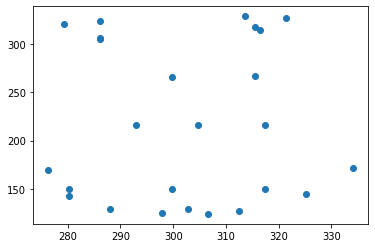

In [15]:
plt.scatter(pose[:,0],pose[:,1])
plt.show()

OH SHIT ITS UPSIDE DOWN

<a id='step3'></a>
## Step 3: Set up models

In [16]:
from model import EncoderCNN, DecoderRNN

# Initialize the encoder and decoder. 
encoder = EncoderCNN(input_size)
decoder = DecoderRNN(input_size, hidden_size, num_layers=2)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.L1Loss().cuda() if torch.cuda.is_available() else nn.L1Loss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) 
# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.0001)

# Set the total number of training steps per epoch.
total_step = math.ceil(data_loader.dataset.num_vids / data_loader.batch_sampler.batch_size)

<a id='step4'></a>
## Step 4: Train models

In [29]:
save_every = 1

In [33]:
# Load the trained weights.
encoder_file = "encoder-5.pkl"
decoder_file = "decoder-5.pkl"

In [34]:
import os
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

<All keys matched successfully>

In [35]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        # Obtain the batch.
        spectrograms, pose_coordinates = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        spectrograms = spectrograms.to(device)
        pose_coordinates = pose_coordinates.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(spectrograms)
        outputs = decoder(features, pose_coordinates.float()) #1x225x50
        
        # Calculate the batch loss.
        loss = criterion(outputs, pose_coordinates)
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, num_epochs, i_step, total_step, loss.item())
        
        # Print training statistics (on same line).
        print('\r' + stats)
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
    
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))       

# Close the training log file.
f.close()

Number of bad frames: 8
Features.shape: torch.Size([1, 50])
Poses.shape: torch.Size([1, 225, 50])
Concat Inputs.shape: torch.Size([1, 225, 50])
Output from LSTM.shape: torch.Size([1, 225, 500])
Output from Linear.shape: torch.Size([1, 225, 50])
Epoch [1/5], Step [1/12], Loss: 40.4710
Number of bad frames: 8
Features.shape: torch.Size([1, 50])
Poses.shape: torch.Size([1, 225, 50])
Concat Inputs.shape: torch.Size([1, 225, 50])
Output from LSTM.shape: torch.Size([1, 225, 500])
Output from Linear.shape: torch.Size([1, 225, 50])
Epoch [1/5], Step [2/12], Loss: 42.0725
Number of bad frames: 8
Features.shape: torch.Size([1, 50])
Poses.shape: torch.Size([1, 225, 50])
Concat Inputs.shape: torch.Size([1, 225, 50])
Output from LSTM.shape: torch.Size([1, 225, 500])
Output from Linear.shape: torch.Size([1, 225, 50])
Epoch [1/5], Step [3/12], Loss: 39.0545
Number of bad frames: 4
Features.shape: torch.Size([1, 50])
Poses.shape: torch.Size([1, 225, 50])
Concat Inputs.shape: torch.Size([1, 225, 50])
O

<a id='step5'></a>
## Step 5: (TODO) Validate models